In [1]:
# https://www.kaggle.com/code/ozlemilgun/market-basket-analysis-with-apriori-algorithm
# https://www.facebook.com/tautologyai/videos/303900072700235
# https://www.kaggle.com/code/ekrembayar/apriori-association-rules-grocery-store
# https://www.youtube.com/watch?v=RDQplhHYUr0

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from itertools import combinations

In [5]:
import json

# 1. Load data

In [6]:
df = pd.read_excel("online_retail_II.xlsx")

In [7]:
df.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
177162,506224,22472,TV DINNER TRAY DOLLY GIRL,1,2010-04-28 11:55:00,11.02,NaN,United Kingdom
88681,497740,22332,SKULLS PARTY BAG + STICKER SET,8,2010-02-12 10:26:00,1.65,13815.0,Germany
7403,490045,21071,VINTAGE BILLBOARD DRINK ME MUG,1,2009-12-03 12:50:00,1.25,17287.0,United Kingdom
16213,490741,22274,FELTCRAFT DOLL EMILY,2,2009-12-07 17:56:00,6.04,NaN,United Kingdom
385321,526411,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2010-10-11 14:05:00,1.25,15834.0,United Kingdom


In [8]:
df.shape

(525461, 8)

# 2. Check data quality

In [9]:
# data type

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [12]:
df['Description'] = df['Description'].str.strip()

In [13]:
# columns name

In [14]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [15]:
# select only useful columns

In [16]:
df = df[['Invoice','StockCode','Description','InvoiceDate']]

In [17]:
# data type

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522530 non-null  object        
 3   InvoiceDate  525461 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 16.0+ MB


In [19]:
# check missing value

In [20]:
df.isna().sum()

Invoice           0
StockCode         0
Description    2931
InvoiceDate       0
dtype: int64

In [21]:
df = df.dropna()

In [22]:
# check white space

In [23]:
def empty_or_whitespace_strings(df):
    string_columns = df.select_dtypes(include=['object']).columns
    empty_whitespace_check = df[string_columns].applymap(lambda x: isinstance(x, str) and x.isspace())

    count_empty_whitespace = empty_whitespace_check.sum()
    rows_with_whitespace_indices = empty_whitespace_check.any(axis=1)
    list_row_with_whilespace_indices = df.index[rows_with_whitespace_indices].tolist()

    return count_empty_whitespace, list_row_with_whilespace_indices

In [24]:
show_whilespace, indices_whilesapce = empty_or_whitespace_strings(df)

In [25]:
show_whilespace

Invoice        0
StockCode      0
Description    0
dtype: int64

In [26]:
# check unique value

In [27]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Invoice
Unique value:  [489434 489435 489436 ... 538169 538170 538171]
Count unique value:  25885
----------
Columns name:  StockCode
Unique value:  [85048 '79323P' '79323W' ... 22935 22933 21120]
Count unique value:  4276
----------
Columns name:  Description
Unique value:  ['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 'WHITE CHERRY LIGHTS' ... '*Boombox Ipod Classic' 'faulty' 'Dotcom sales']
Count unique value:  4640
----------
Columns name:  InvoiceDate
Unique value:  <DatetimeArray>
['2009-12-01 07:45:00', '2009-12-01 07:46:00', '2009-12-01 09:06:00',
 '2009-12-01 09:08:00', '2009-12-01 09:24:00', '2009-12-01 09:28:00',
 '2009-12-01 09:43:00', '2009-12-01 09:44:00', '2009-12-01 09:46:00',
 '2009-12-01 09:50:00',
 ...
 '2010-12-09 17:25:00', '2010-12-09 17:27:00', '2010-12-09 17:32:00',
 '2010-12-09 17:34:00', '2010-12-09 18:09:00', '2010-12-09 18:58:00',
 '2010-12-09 19:23:00', '2010-12-09 19:28:00', '2010-12-09 19:32:00',
 '2010-12-09 20:01:00']
Lengt

In [28]:
# check Description

In [29]:
description_counts = df.groupby('StockCode').agg(number_description=('Description', pd.Series.nunique)).reset_index()

In [30]:
multiple_descriptions = description_counts[description_counts['number_description'] > 1]

In [31]:
multiple_descriptions = multiple_descriptions.sort_values("number_description", ascending=False)

In [32]:
multiple_descriptions

,StockCode,number_description
1522,22423,6
1817,22734,5
3805,85099B,4
1454,22345,4
1453,22344,4
...,...,...
1476,22367,2
1486,22381,2
1487,22382,2
1488,22383,2


In [33]:
df[df['StockCode'] == 'DCGSSGIRL']

,Invoice,StockCode,Description,InvoiceDate
241372,512738,DCGSSGIRL,update,2010-06-17 14:11:00
244831,513099,DCGSSGIRL,GIRLS PARTY BAG,2010-06-21 15:13:00
246184,513200,DCGSSGIRL,GIRLS PARTY BAG,2010-06-22 16:28:00
249938,513574,DCGSSGIRL,GIRLS PARTY BAG,2010-06-25 15:13:00
251930,513655,DCGSSGIRL,GIRLS PARTY BAG,2010-06-28 10:02:00
253997,513907,DCGSSGIRL,GIRLS PARTY BAG,2010-06-29 12:08:00
385192,526405,DCGSSGIRL,GIRLS PARTY BAG,2010-10-11 13:53:00
425616,530060,DCGSSGIRL,GIRLS PARTY BAG,2010-11-01 11:35:00
427107,530140,DCGSSGIRL,GIRLS PARTY BAG,2010-11-01 16:45:00
465555,533338,DCGSSGIRL,GIRLS PARTY BAG,2010-11-16 18:18:00


In [34]:
df = df[~df['StockCode'].isin(multiple_descriptions['StockCode'])]

In [35]:
# check StockCode

In [36]:
stockcode_counts = df.groupby('Description').agg(number_stockcode=('StockCode', pd.Series.nunique)).reset_index()

In [37]:
multiple_stockcode = stockcode_counts[stockcode_counts['number_stockcode'] > 1]

In [38]:
multiple_stockcode = multiple_stockcode.sort_values("number_stockcode", ascending=False)

In [39]:
multiple_stockcode

,Description,number_stockcode
1851,"METAL SIGN,CUPCAKE SINGLE HOOK",6
810,COLUMBIAN CANDLE ROUND,4
3462,damages,3
1907,MODERN CHRISTMAS TREE CANDLE,3
807,COLOURING PENCILS BROWN TUBE,3
...,...,...
1112,FAIRY CAKE DESIGN UMBRELLA,2
1111,FAIRY CAKE CERAMIC BUTTER DISH,2
1076,ENGLISH ROSE NOTEBOOK A7 SIZE,2
1071,ENGLISH ROSE HOT WATER BOTTLE,2


In [40]:
df[df['Description'] == 'damages']

,Invoice,StockCode,Description,InvoiceDate
3168,489663,35605A,damages,2009-12-01 18:02:00
73227,496006,84641,damages,2010-01-28 12:30:00
91575,498034,35978,damages,2010-02-16 10:08:00
265660,515069,35978,damages,2010-07-08 10:57:00


In [41]:
df = df[~df['Description'].isin(multiple_stockcode['Description'])]

In [42]:
# check unique value (again)

In [43]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Invoice
Unique value:  [489434 489436 489437 ... 538169 538170 538171]
Count unique value:  22959
----------
Columns name:  StockCode
Unique value:  [85048 '79323P' '79323W' ... 22935 22933 21120]
Count unique value:  3329
----------
Columns name:  Description
Unique value:  ['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 'WHITE CHERRY LIGHTS' ... 'BAKING MOULD ROSE MILK CHOCOLATE'
 'BAKING MOULD EASTER EGG MILK CHOC' '*Boombox Ipod Classic']
Count unique value:  3329
----------
Columns name:  InvoiceDate
Unique value:  <DatetimeArray>
['2009-12-01 07:45:00', '2009-12-01 09:06:00', '2009-12-01 09:08:00',
 '2009-12-01 09:24:00', '2009-12-01 09:28:00', '2009-12-01 09:44:00',
 '2009-12-01 09:46:00', '2009-12-01 09:50:00', '2009-12-01 09:55:00',
 '2009-12-01 09:57:00',
 ...
 '2010-12-09 16:53:00', '2010-12-09 16:57:00', '2010-12-09 17:27:00',
 '2010-12-09 17:34:00', '2010-12-09 18:09:00', '2010-12-09 18:58:00',
 '2010-12-09 19:23:00', '2010-12-09 19:28:00', '201

In [44]:
# manual Description check

In [45]:
df_check_description = df[['Description']].drop_duplicates()

In [46]:
def char_count(row):
    return len(set(str(row)))

In [47]:
def lowercase_count(row):
    lowercase_letters = set(char for word in row.split() for char in word if char.islower())
    return len(lowercase_letters)

In [48]:
df_check_description['Description_char_count'] = df_check_description['Description'].apply(char_count)

In [49]:
df_check_description['Description_lower_char_count'] = df_check_description['Description'].apply(lowercase_count)

In [50]:
df_check_description.to_excel('check_description.xlsx', index = False)

In [51]:
# given away
# Adjust bad debt
# Discount
# damaged
# rex use
# lost
# ?
# SAMPLES

In [52]:
df = df[~df['Description'].isin(['given away','Adjust bad debt','Discount','damaged','rex use','lost','?','SAMPLES'])]

# 3. Exploratory data analysis (EDA)

In [53]:
df.sample(5)

,Invoice,StockCode,Description,InvoiceDate
357329,524097,22088,PAPER BUNTING COLOURED LACE,2010-09-27 12:16:00
83063,497027,22275,WEEKEND BAG VINTAGE ROSE PAISLEY,2010-02-05 13:17:00
30820,491969,22113,GREY HEART HOT WATER BOTTLE,2009-12-14 17:57:00
203829,509033,21754,HOME BUILDING BLOCK WORD,2010-05-19 17:49:00
386580,526585,10002,INFLATABLE POLITICAL GLOBE,2010-10-12 11:52:00


In [54]:
# Top 100 Count of Transactions by Description

In [55]:
description_counts = df['Description'].value_counts().head(100)
description_counts = description_counts.sort_values(ascending=False)

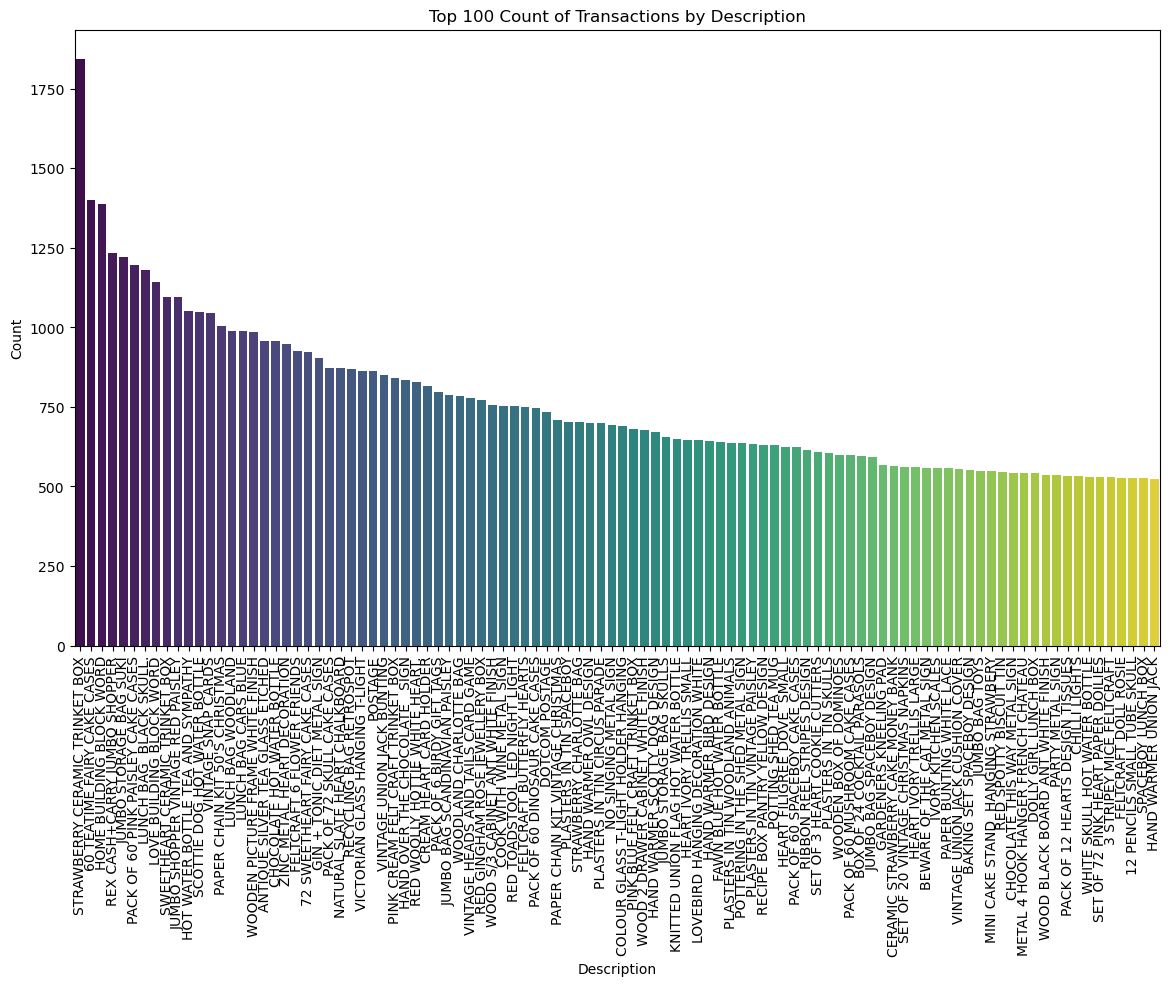

In [56]:
plt.figure(figsize=(14, 8))
sns.barplot(x=description_counts.index, y=description_counts.values, palette='viridis')
plt.title('Top 100 Count of Transactions by Description')
plt.xlabel('Description')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [57]:
# Top 100 Count of Transactions by Invoice

In [58]:
invoice_counts = df['Invoice'].value_counts().head(100)
invoice_counts = invoice_counts.sort_values(ascending=False)

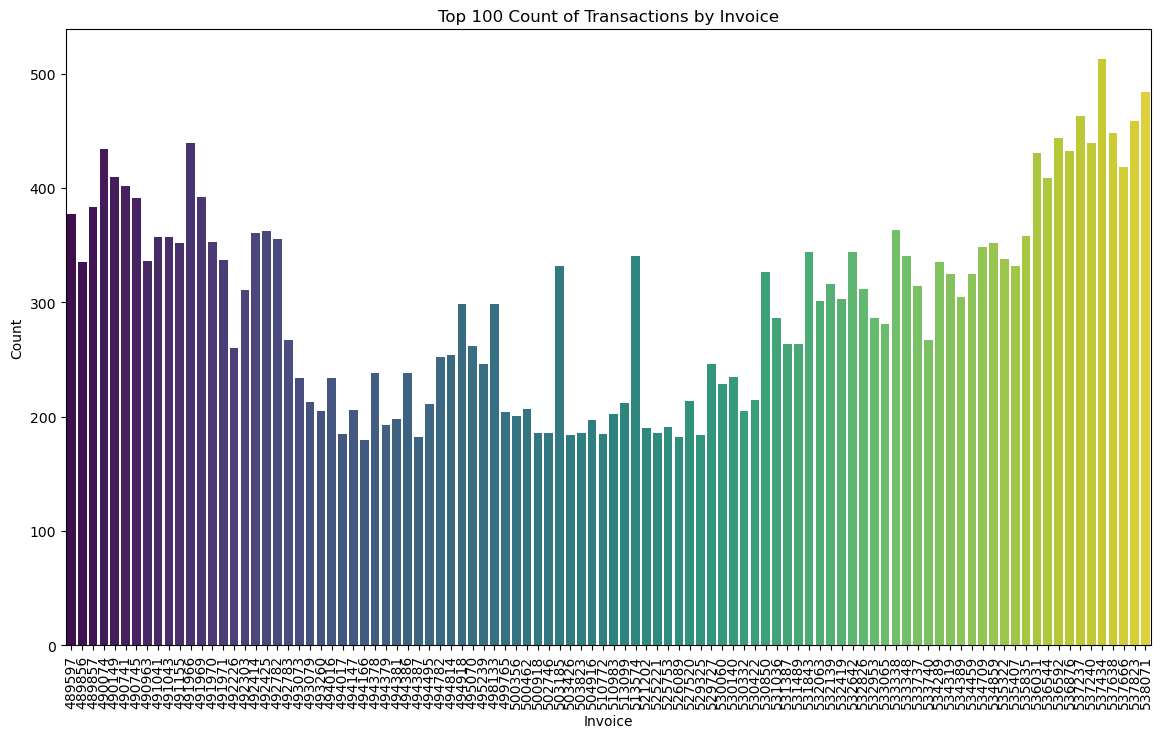

In [59]:
plt.figure(figsize=(14, 8))
sns.barplot(x=invoice_counts.index, y=invoice_counts.values, palette='viridis')
plt.title('Top 100 Count of Transactions by Invoice')
plt.xlabel('Invoice')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.show()

In [60]:
# Count of Transactions by Day of Week and Month of Year

In [61]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['MonthOfYear'] = df['InvoiceDate'].dt.month

In [62]:
transaction_counts = df.groupby(['MonthOfYear', 'DayOfWeek']).size().unstack(fill_value=0)

In [63]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
transaction_counts = transaction_counts.reindex(columns=days_order, fill_value=0)

In [64]:
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
transaction_counts.index = transaction_counts.index.map(month_names)

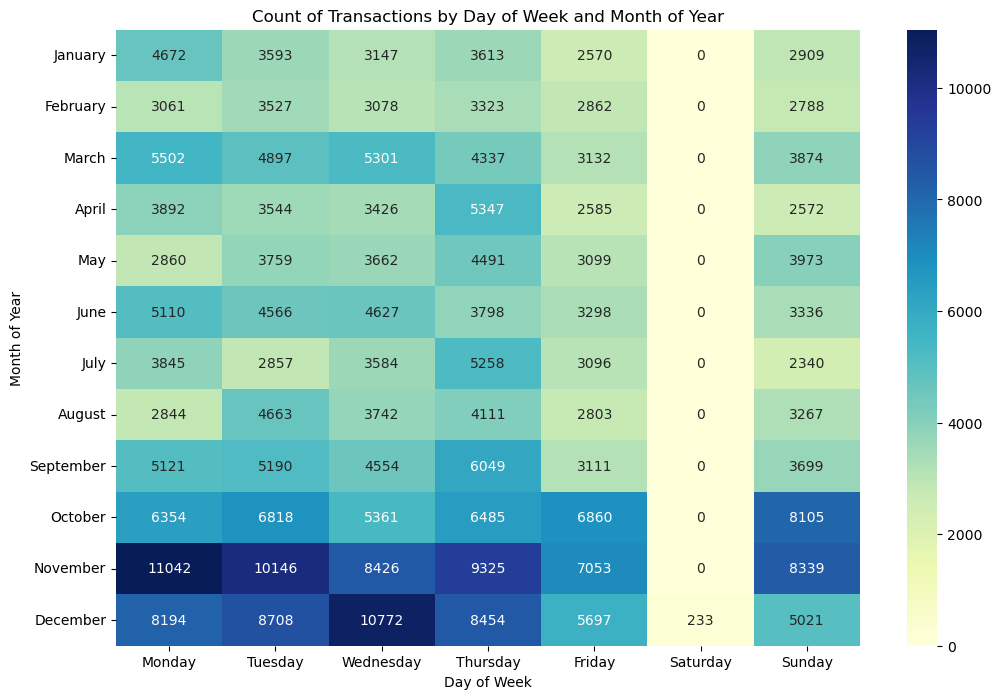

In [65]:
plt.figure(figsize=(12, 8))
sns.heatmap(transaction_counts, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Count of Transactions by Day of Week and Month of Year')
plt.xlabel('Day of Week')
plt.ylabel('Month of Year')
plt.show()

In [66]:
# apply this logic to select minimum support (>= once per weeks)
# https://medium.com/@psicecream/%E0%B8%A1%E0%B8%B7%E0%B8%AD%E0%B9%83%E0%B8%AB%E0%B8%A1%E0%B9%88%E0%B8%AB%E0%B8%B1%E0%B8%94%E0%B8%97%E0%B8%B3-data-mining-%E0%B8%94%E0%B9%89%E0%B8%A7%E0%B8%A2-apriori-algorithm-%E0%B8%9A%E0%B8%99-python-3b650f48e675

In [67]:
no_txn = len(df['Invoice'].unique().tolist())

In [68]:
no_week = df['InvoiceDate'].dt.isocalendar().week.nunique()

In [69]:
txn_per_week = no_txn/(no_week)

In [70]:
min_support = txn_per_week/no_txn

In [71]:
print('Number of unique transactions:', no_txn)
print('Number of unique weeks:', no_week)
print('Transactions per week:', txn_per_week)
print('Minimum support:', min_support/2)

Number of unique transactions: 22846
Number of unique weeks: 52
Transactions per week: 439.34615384615387
Minimum support: 0.009615384615384616


# 4. Model

In [72]:
# set list

In [73]:
txn_list = df.groupby('Invoice')['Description'].apply(list).tolist()

In [74]:
item_list = df['Description'].unique().tolist()

In [75]:
max_no_item_invoice = df.groupby('Invoice')['Description'].nunique().reset_index()['Description'].max()

In [76]:
# first step (support)

In [77]:
store_item = []
store_support = []

In [78]:
min_support = min_support
# min_support = 0.002

In [79]:
for round in range(1,max_no_item_invoice+1,1):
    if round == 1:
        print('size of list:', round)
        item_set_list = list(combinations(item_list, round))
    else:
        print('size of list:', round)
        item_list = sorted(list(set([item for sublist in item_set_list for item in sublist])))
        item_set_list = list(combinations(item_list, round))        

    support_item_set_list = []
    initial_denominator = len(txn_list)
    initial_support = 0
    for item in item_set_list:
        initial_nominator = 0
        for txn in txn_list:
            if set(item).issubset(set(txn)) == True:
                initial_nominator += 1
        initial_support = initial_nominator/initial_denominator
        support_item_set_list.append(initial_support)

    index_to_drop_list = []
    for index, (item, support) in enumerate(zip(item_set_list, support_item_set_list)):
        print(index, item, support)
        if support < min_support:
            index_to_drop_list.append(index)

    item_set_list = [item for index, item in enumerate(item_set_list) if index not in index_to_drop_list]
    support_item_set_list = [item for index, item in enumerate(support_item_set_list) if index not in index_to_drop_list]

    store_item = store_item + item_set_list
    store_support = store_support + support_item_set_list

size of list: 1
0 ('15CM CHRISTMAS GLASS BALL 20 LIGHTS',) 0.013569114943534973
1 ('PINK CHERRY LIGHTS',) 0.015232425807581195
2 ('WHITE CHERRY LIGHTS',) 0.020660071784995186
3 ('RECORD FRAME 7" SINGLE SIZE',) 0.00927952376783682
4 ('STRAWBERRY CERAMIC TRINKET BOX',) 0.07734395517814935
5 ('PINK DOUGHNUT TRINKET POT',) 0.021404184539963234
6 ('SAVE THE PLANET MUG',) 0.02035367241530246
7 ('LOVE BUILDING BLOCK WORD',) 0.04827978639586798
8 ('HOME BUILDING BLOCK WORD',) 0.05869736496542064
9 ('PEACE WOODEN BLOCK LETTERS',) 0.010855291954827978
10 ('CHRISTMAS CRAFT WHITE FAIRY',) 0.006697014794712422
11 ('HEART IVORY TRELLIS LARGE',) 0.023417666112229712
12 ('HEART FILIGREE DOVE LARGE',) 0.020835157139105314
13 ('FULL ENGLISH BREAKFAST PLATE',) 0.016676879978989756
14 ('PIZZA PLATE IN BOX',) 0.009454609121946948
15 ('BLACK DINER WALL CLOCK',) 0.005383874638886457
16 ('BATH BUILDING BLOCK WORD',) 0.014400770375558085
17 ('CLASSIC WHITE FRAME',) 0.009717237153112143
18 ('BISCUITS SMALL BOWL

In [80]:
# second step (confident)

In [81]:
rules = []

In [82]:
for index, (item, support) in enumerate(zip(store_item, store_support)):
    if len(item) == 1:
        pass
    else:
        n = len(item)
        for r in range(1, n):
            item_combinations = combinations(item, r)
            for item_set in item_combinations:
                remaining_items = tuple(x for x in item if x not in item_set)
                rule = (item_set, remaining_items)
                rules.append(rule)

In [83]:
rules

[(('60 TEATIME FAIRY CAKE CASES',), ('72 SWEETHEART FAIRY CAKE CASES',)),
 (('72 SWEETHEART FAIRY CAKE CASES',), ('60 TEATIME FAIRY CAKE CASES',)),
 (('60 TEATIME FAIRY CAKE CASES',), ('PACK OF 60 PINK PAISLEY CAKE CASES',)),
 (('PACK OF 60 PINK PAISLEY CAKE CASES',), ('60 TEATIME FAIRY CAKE CASES',)),
 (('CHOCOLATE HOT WATER BOTTLE',), ('HOT WATER BOTTLE TEA AND SYMPATHY',)),
 (('HOT WATER BOTTLE TEA AND SYMPATHY',), ('CHOCOLATE HOT WATER BOTTLE',)),
 (('HOME BUILDING BLOCK WORD',), ('LOVE BUILDING BLOCK WORD',)),
 (('LOVE BUILDING BLOCK WORD',), ('HOME BUILDING BLOCK WORD',)),
 (('STRAWBERRY CERAMIC TRINKET BOX',), ('SWEETHEART CERAMIC TRINKET BOX',)),
 (('SWEETHEART CERAMIC TRINKET BOX',), ('STRAWBERRY CERAMIC TRINKET BOX',)),
 (('VINTAGE HEADS AND TAILS CARD GAME',), ('VINTAGE SNAP CARDS',)),
 (('VINTAGE SNAP CARDS',), ('VINTAGE HEADS AND TAILS CARD GAME',))]

# 5. Save model

In [88]:
results = []

In [89]:
for rule in rules:
    tran_count_union = rule[0] + rule[1]
    tran_count = rule[0]
    initial_nominator = 0
    initial_denominator = 0
    for txn in txn_list:
        if set(tran_count_union).issubset(set(txn)) == True:
            initial_nominator += 1
        if set(tran_count).issubset(set(txn)) == True:
            initial_denominator += 1

    if initial_denominator != 0 and initial_nominator / initial_denominator >= 0.01:
        result = {
            "origin": rule[0],
            "destination": rule[1],
            "confidence": initial_nominator / initial_denominator
        }
        results.append(result)

In [90]:
results

[{'origin': ('60 TEATIME FAIRY CAKE CASES',),
  'destination': ('72 SWEETHEART FAIRY CAKE CASES',),
  'confidence': 0.3524590163934426},
 {'origin': ('72 SWEETHEART FAIRY CAKE CASES',),
  'destination': ('60 TEATIME FAIRY CAKE CASES',),
  'confidence': 0.5411899313501144},
 {'origin': ('60 TEATIME FAIRY CAKE CASES',),
  'destination': ('PACK OF 60 PINK PAISLEY CAKE CASES',),
  'confidence': 0.4433681073025335},
 {'origin': ('PACK OF 60 PINK PAISLEY CAKE CASES',),
  'destination': ('60 TEATIME FAIRY CAKE CASES',),
  'confidence': 0.5129310344827587},
 {'origin': ('CHOCOLATE HOT WATER BOTTLE',),
  'destination': ('HOT WATER BOTTLE TEA AND SYMPATHY',),
  'confidence': 0.5144694533762058},
 {'origin': ('HOT WATER BOTTLE TEA AND SYMPATHY',),
  'destination': ('CHOCOLATE HOT WATER BOTTLE',),
  'confidence': 0.46875},
 {'origin': ('HOME BUILDING BLOCK WORD',),
  'destination': ('LOVE BUILDING BLOCK WORD',),
  'confidence': 0.4377330350484713},
 {'origin': ('LOVE BUILDING BLOCK WORD',),
  'des

In [91]:
with open("output.json", "a") as json_file:
    json.dump(results, json_file, indent=4)
    json_file.write('\n')